Predict model on year/months and turn to tif.  Save a tif of both probabilities and binary 1,0. 

Smoke test

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Predict burned probabilities and classes for (year, month) = (2014, 7),
using the saved Option 2 model for NEG=40% & neg_class_weight=3 and your
partitioned Parquet dataset.

Outputs:
  - <OUT_PRED_DIR>/proba/cems_pred_proba_2014_07.tif
  - <OUT_PRED_DIR>/class/cems_pred_class_2014_07_thr{thr}.tif
"""

import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa

import rasterio as rio
from rasterio.warp import transform as rio_transform
from rasterio.transform import rowcol

import lightgbm as lgb
import joblib

# ============================ CONFIG ============================
YEAR = 2014
MONTH = 7  # July

# Where your ORIGINAL template monthly TIFFs live (used for georeference/shape)
IN_TIF_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction"

# The Parquet dataset you built from those TIFFs (partitioned by year=/month=)
PARQUET_DATASET_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset"

# Saved model metadata JSON for NEG=40% & w_neg=3 from your penalize-FP run
MODEL_META_JSON = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/"
    "neg_ratio_experiments_globaltest/option2_scale_pos_weight_penalize_fp/"
    "saved_model_neg040pct_w3/model_meta_neg040pct_w3.json"
)

# Where to save prediction rasters
OUT_PRED_DIR = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "predictions_option2_neg040pct_w3"
)
os.makedirs(os.path.join(OUT_PRED_DIR, "proba"), exist_ok=True)
os.makedirs(os.path.join(OUT_PRED_DIR, "class"), exist_ok=True)

# If True, the Parquet lon/lat are EPSG:4326 and will be reprojected into the template CRS
PARQUET_COORDS_ARE_EPSG4326 = True

# Batch size for reading Parquet (rows per chunk)
PARQUET_BATCH_ROWS = 1_000_000

# ================================================================
# Helpers
# ================================================================
name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})", re.IGNORECASE)

def parse_year_month(fname: str):
    m = name_re.search(fname)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

def find_template_tif(year: int, month: int) -> Path:
    patterns = [
        f"cems_e5l_firecci_{year}_{month}_with_fraction.tif",
        f"cems_e5l_firecci_{year}_{month}.tif",
        f"cems_e5l_firecci_{year}_{month:02d}_with_fraction.tif",
        f"cems_e5l_firecci_{year}_{month:02d}.tif",
    ]
    for p in patterns:
        cand = Path(IN_TIF_DIR) / p
        if cand.exists():
            return cand
    for tif in Path(IN_TIF_DIR).glob(f"cems_e5l_firecci_{year}_*.tif"):
        y, m = parse_year_month(tif.name)
        if y == year and m == month:
            return tif
    return None

def load_model_and_meta(meta_json_path: str):
    with open(meta_json_path, "r") as f:
        meta = json.load(f)
    pkl_path = meta["paths"].get("sklearn_pkl")
    booster_txt = meta["paths"].get("booster_txt")
    predictors = meta.get("predictors", [])
    b1_cats = None
    if meta.get("categorical", {}).get("b1_categories") is not None:
        b1_cats = [str(x) for x in meta["categorical"]["b1_categories"]]
    threshold = float(meta.get("threshold", 0.5))
    best_iteration = meta.get("best_iteration", -1)

    if pkl_path and os.path.exists(pkl_path):
        model = joblib.load(pkl_path)  # LGBMClassifier
        booster = model.booster_
        model_is_sklearn = True
    elif booster_txt and os.path.exists(booster_txt):
        booster = lgb.Booster(model_file=booster_txt)
        model = booster
        model_is_sklearn = False
    else:
        raise FileNotFoundError("Neither sklearn_pkl nor booster_txt found from metadata paths.")

    return model, booster, predictors, b1_cats, threshold, best_iteration, meta

def ensure_predictor_frame(df: pd.DataFrame, predictors: list, b1_cats):
    # Add missing predictor columns as NaN to match training schema
    for c in predictors:
        if c not in df.columns:
            df[c] = np.nan
    X = df[predictors].copy()

    # 'b1' categorical handling
    if "b1" in X.columns:
        X["b1"] = X["b1"].astype("string")
        if b1_cats is not None:
            X["b1"] = pd.Categorical(X["b1"], categories=b1_cats)
        else:
            X["b1"] = pd.Categorical(X["b1"])

    # Coerce non-categorical to numeric
    for c in X.columns:
        if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
            continue
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

def write_geotiff(path, array2d, template_ds, nodata=np.nan, dtype="float32"):
    profile = template_ds.profile.copy()
    profile.update(
        count=1,
        dtype=dtype,
        nodata=nodata if (isinstance(nodata, (int, float)) and not np.isnan(nodata)) else None,
        compress="deflate",
        predictor=2,
        tiled=True
    )
    with rio.open(path, "w", **profile) as dst:
        dst.write(array2d.astype(dtype), 1)

# ================================================================
# Load model + metadata
# ================================================================
model, booster, predictors, b1_cats, THRESH_PROBA, best_iter, meta = load_model_and_meta(MODEL_META_JSON)
print(f"[Model loaded: NEG=40%, w=3]\n- Threshold: {THRESH_PROBA:.3f}\n- Best iteration: {best_iter}\n- #predictors: {len(predictors)}")

# ================================================================
# Locate template for YEAR-MONTH
# ================================================================
template_path = find_template_tif(YEAR, MONTH)
if template_path is None:
    raise RuntimeError(f"No template TIF found in {IN_TIF_DIR} for {YEAR}-{MONTH:02d}")

# ================================================================
# Predict for requested YEAR-MONTH
# ================================================================
with rio.open(template_path) as tpl:
    height, width = tpl.height, tpl.width
    transform = tpl.transform
    dst_crs = tpl.crs

    proba_arr = np.full((height, width), np.nan, dtype="float32")
    class_arr = np.full((height, width), 255, dtype="uint8")  # 255 as nodata for class

    # Read parquet partition via Scanner (compat with older PyArrow)
    dataset = ds.dataset(PARQUET_DATASET_DIR, format="parquet", partitioning="hive")
    filt = (ds.field("year") == YEAR) & (ds.field("month") == MONTH)
    needed_cols = list(set(predictors + ["longitude", "latitude", "year", "month"]))

    scanner = ds.Scanner.from_dataset(
        dataset,
        columns=needed_cols,
        filter=filt,
        batch_size=PARQUET_BATCH_ROWS
    )

    total_rows = 0
    written_rows = 0

    for batch in scanner.to_batches():
        if batch.num_rows == 0:
            continue
        tbl = pa.Table.from_batches([batch])
        df = tbl.to_pandas()
        total_rows += len(df)
        if len(df) == 0:
            continue

        if "longitude" not in df.columns or "latitude" not in df.columns:
            raise ValueError("Parquet dataset must include 'longitude' and 'latitude' columns.")

        lons = df["longitude"].to_numpy(dtype="float64", copy=False)
        lats = df["latitude"].to_numpy(dtype="float64", copy=False)

        # Build predictors frame with correct order/types
        X = ensure_predictor_frame(df, predictors, b1_cats)

        # Predict probabilities
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X, num_iteration=getattr(model, "best_iteration_", None))[:, 1]
        else:
            proba = booster.predict(X, num_iteration=best_iter if isinstance(best_iter, int) and best_iter > 0 else None)

        # Map coordinates to row/col in template CRS
        if PARQUET_COORDS_ARE_EPSG4326 and (dst_crs is not None) and (dst_crs.to_string().upper() not in ("EPSG:4326", "OGC:CRS84")):
            xs, ys = rio_transform("EPSG:4326", dst_crs, lons, lats)
        else:
            xs, ys = lons, lats

        # Convert to row/col (chunked to avoid overhead)
        step = 500_000
        npts = len(xs)
        rows_all = np.empty(npts, dtype=np.int64)
        cols_all = np.empty(npts, dtype=np.int64)
        for s in range(0, npts, step):
            e = s + step
            rr, cc = rowcol(transform, xs[s:e], ys[s:e], op=round)
            rows_all[s:e] = rr
            cols_all[s:e] = cc

        # Keep only points inside raster bounds
        mask_in = (
            (rows_all >= 0) & (rows_all < height) &
            (cols_all >= 0) & (cols_all < width)
        )
        if not np.any(mask_in):
            continue

        rr = rows_all[mask_in]
        cc = cols_all[mask_in]
        pp = proba[mask_in]

        # Write to arrays
        proba_arr[rr, cc] = pp.astype("float32")
        class_arr[rr, cc] = (pp >= THRESH_PROBA).astype("uint8")
        written_rows += int(mask_in.sum())

    # Save rasters
    out_proba = Path(OUT_PRED_DIR) / "proba" / f"cems_pred_proba_{YEAR}_{MONTH:02d}.tif"
    out_class = Path(OUT_PRED_DIR) / "class" / f"cems_pred_class_{YEAR}_{MONTH:02d}_thr{THRESH_PROBA:.3f}.tif"

    write_geotiff(str(out_proba), proba_arr, tpl, nodata=np.nan, dtype="float32")
    write_geotiff(str(out_class), class_arr, tpl, nodata=255, dtype="uint8")

    print(f"[{YEAR}-{MONTH:02d}] wrote {written_rows:,}/{total_rows:,} rows ->")
    print(f"  - {out_proba}")
    print(f"  - {out_class}")

print("✅ Done. Predictions written.")


[Model loaded: NEG=40%, w=3]
- Threshold: 0.414
- Best iteration: 100
- #predictors: 15
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current va

In [ ]:
all_years

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch predict burned probabilities and classes for ALL requested years/months
using the saved Option 2 model (NEG=40%, neg_class_weight=3).

Outputs per (year, month):
  - <OUT_PRED_DIR>/proba/cems_pred_proba_{YYYY}_{MM}.tif
  - <OUT_PRED_DIR>/class/cems_pred_class_{YYYY}_{MM}_thr{thr}.tif
"""

import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa

import rasterio as rio
from rasterio.warp import transform as rio_transform
from rasterio.transform import rowcol

import lightgbm as lgb
import joblib

# ============================ CONFIG ============================
# Years & months to process
YEARS  = list(range(2001, 2025))   # change as needed
MONTHS = list(range(1, 13))        # 1..12

# Where your ORIGINAL template monthly TIFFs live (for georeference/shape)
IN_TIF_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction"

# The Parquet dataset you built from those TIFFs (partitioned by year=/month=)
PARQUET_DATASET_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset"

# Saved model metadata JSON for NEG=40% & w_neg=3 from the penalize-FP run
MODEL_META_JSON = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/"
    "neg_ratio_experiments_globaltest/option2_scale_pos_weight_penalize_fp/"
    "saved_model_neg040pct_w3/model_meta_neg040pct_w3.json"
)

# Where to save prediction rasters
OUT_PRED_DIR = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "predictions_option2_neg040pct_w3"
)
os.makedirs(os.path.join(OUT_PRED_DIR, "proba"), exist_ok=True)
os.makedirs(os.path.join(OUT_PRED_DIR, "class"), exist_ok=True)

# Parquet lon/lat handling
PARQUET_COORDS_ARE_EPSG4326 = True

# Batch size for reading Parquet
PARQUET_BATCH_ROWS = 1_000_000

# ================================================================
# Helpers
# ================================================================
name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})", re.IGNORECASE)

def parse_year_month(fname: str):
    m = name_re.search(fname)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

def find_template_tif(year: int, month: int) -> Path:
    """Find the template GeoTIFF for the given year/month."""
    patterns = [
        f"cems_e5l_firecci_{year}_{month}_with_fraction.tif",
        f"cems_e5l_firecci_{year}_{month}.tif",
        f"cems_e5l_firecci_{year}_{month:02d}_with_fraction.tif",
        f"cems_e5l_firecci_{year}_{month:02d}.tif",
    ]
    for p in patterns:
        cand = Path(IN_TIF_DIR) / p
        if cand.exists():
            return cand
    for tif in Path(IN_TIF_DIR).glob(f"cems_e5l_firecci_{year}_*.tif"):
        y, m = parse_year_month(tif.name)
        if y == year and m == month:
            return tif
    return None

def load_model_and_meta(meta_json_path: str):
    """Load model + metadata; return (model, booster, predictors, b1_cats, threshold, best_iter, meta)."""
    with open(meta_json_path, "r") as f:
        meta = json.load(f)
    pkl_path = meta["paths"].get("sklearn_pkl")
    booster_txt = meta["paths"].get("booster_txt")
    predictors = meta.get("predictors", [])
    b1_cats = None
    if meta.get("categorical", {}).get("b1_categories") is not None:
        b1_cats = [str(x) for x in meta["categorical"]["b1_categories"]]
    threshold = float(meta.get("threshold", 0.5))
    best_iteration = meta.get("best_iteration", -1)

    if pkl_path and os.path.exists(pkl_path):
        model = joblib.load(pkl_path)  # LGBMClassifier
        booster = model.booster_
    elif booster_txt and os.path.exists(booster_txt):
        booster = lgb.Booster(model_file=booster_txt)
        model = booster
    else:
        raise FileNotFoundError("Neither sklearn_pkl nor booster_txt found from metadata paths.")

    return model, booster, predictors, b1_cats, threshold, best_iteration, meta

def ensure_predictor_frame(df: pd.DataFrame, predictors: list, b1_cats):
    """Ensure df has all predictor columns with correct types/order."""
    for c in predictors:
        if c not in df.columns:
            df[c] = np.nan
    X = df[predictors].copy()

    if "b1" in X.columns:
        X["b1"] = X["b1"].astype("string")
        if b1_cats is not None:
            X["b1"] = pd.Categorical(X["b1"], categories=b1_cats)
        else:
            X["b1"] = pd.Categorical(X["b1"])

    for c in X.columns:
        if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
            continue
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

def write_geotiff(path, array2d, template_ds, nodata=np.nan, dtype="float32"):
    profile = template_ds.profile.copy()
    profile.update(
        count=1,
        dtype=dtype,
        nodata=nodata if (isinstance(nodata, (int, float)) and not np.isnan(nodata)) else None,
        compress="deflate",
        predictor=2,
        tiled=True
    )
    with rio.open(path, "w", **profile) as dst:
        dst.write(array2d.astype(dtype), 1)

# ================================================================
# Load model + metadata
# ================================================================
model, booster, predictors, b1_cats, THRESH_PROBA, best_iter, meta = load_model_and_meta(MODEL_META_JSON)
print(f"[Model loaded: NEG=40%, w=3]")
print(f"  - Threshold: {THRESH_PROBA:.3f}")
print(f"  - Best iteration: {best_iter}")
print(f"  - #predictors: {len(predictors)}")

# Prepare Parquet dataset handle once
dataset = ds.dataset(PARQUET_DATASET_DIR, format="parquet", partitioning="hive")

# ================================================================
# Predict for requested YEARS × MONTHS
# ================================================================
for YEAR in YEARS:
    for MONTH in MONTHS:
        template_path = find_template_tif(YEAR, MONTH)
        if template_path is None:
            print(f"[SKIP] No template TIF in {IN_TIF_DIR} for {YEAR}-{MONTH:02d}")
            continue

        print(f"\n=== Predicting {YEAR}-{MONTH:02d} ===")

        with rio.open(template_path) as tpl:
            height, width = tpl.height, tpl.width
            transform = tpl.transform
            dst_crs = tpl.crs

            proba_arr = np.full((height, width), np.nan, dtype="float32")
            class_arr = np.full((height, width), 255, dtype="uint8")  # 255 nodata

            filt = (ds.field("year") == YEAR) & (ds.field("month") == MONTH)
            needed_cols = list(set(predictors + ["longitude", "latitude", "year", "month"]))

            scanner = ds.Scanner.from_dataset(
                dataset, columns=needed_cols, filter=filt, batch_size=PARQUET_BATCH_ROWS
            )

            total_rows = 0
            written_rows = 0

            for batch in scanner.to_batches():
                if batch.num_rows == 0:
                    continue
                tbl = pa.Table.from_batches([batch])
                df = tbl.to_pandas()
                total_rows += len(df)
                if len(df) == 0:
                    continue

                if "longitude" not in df.columns or "latitude" not in df.columns:
                    raise ValueError("Parquet dataset must include 'longitude' and 'latitude' columns.")

                lons = df["longitude"].to_numpy(dtype="float64", copy=False)
                lats = df["latitude"].to_numpy(dtype="float64", copy=False)

                # Build predictors frame with correct order/types
                X = ensure_predictor_frame(df, predictors, b1_cats)

                # Predict probabilities
                if hasattr(model, "predict_proba"):
                    proba = model.predict_proba(X, num_iteration=getattr(model, "best_iteration_", None))[:, 1]
                else:
                    proba = booster.predict(
                        X,
                        num_iteration=best_iter if isinstance(best_iter, int) and best_iter > 0 else None
                    )

                # Map coordinates to row/col in template CRS
                if PARQUET_COORDS_ARE_EPSG4326 and (dst_crs is not None) and (dst_crs.to_string().upper() not in ("EPSG:4326", "OGC:CRS84")):
                    xs, ys = rio_transform("EPSG:4326", dst_crs, lons, lats)
                else:
                    xs, ys = lons, lats

                # Convert to row/col (chunked to avoid overhead)
                step = 500_000
                npts = len(xs)
                rows_all = np.empty(npts, dtype=np.int64)
                cols_all = np.empty(npts, dtype=np.int64)
                for s in range(0, npts, step):
                    e = s + step
                    rr, cc = rowcol(transform, xs[s:e], ys[s:e], op=round)
                    rows_all[s:e] = rr
                    cols_all[s:e] = cc

                # Keep only points inside raster bounds
                mask_in = (
                    (rows_all >= 0) & (rows_all < height) &
                    (cols_all >= 0) & (cols_all < width)
                )
                if not np.any(mask_in):
                    continue

                rr = rows_all[mask_in]
                cc = cols_all[mask_in]
                pp = proba[mask_in]

                # Write to arrays
                proba_arr[rr, cc] = pp.astype("float32")
                class_arr[rr, cc] = (pp >= THRESH_PROBA).astype("uint8")
                written_rows += int(mask_in.sum())

            # Save rasters
            out_proba = Path(OUT_PRED_DIR) / "proba" / f"cems_pred_proba_{YEAR}_{MONTH:02d}.tif"
            out_class = Path(OUT_PRED_DIR) / "class" / f"cems_pred_class_{YEAR}_{MONTH:02d}_thr{THRESH_PROBA:.3f}.tif"

            write_geotiff(str(out_proba), proba_arr, tpl, nodata=np.nan, dtype="float32")
            write_geotiff(str(out_class), class_arr, tpl, nodata=255, dtype="uint8")

            print(f"[{YEAR}-{MONTH:02d}] wrote {written_rows:,}/{total_rows:,} rows ->")
            print(f"  - {out_proba}")
            print(f"  - {out_class}")

print("\n✅ Done. All requested predictions written.")


[Model loaded: NEG=40%, w=3]
  - Threshold: 0.414
  - Best iteration: 100
  - #predictors: 15

=== Predicting 2001-01 ===
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytr

In [ ]:
Precision vs recall ruves


[INFO] Available curves discovered:
  - neg=10%, w=1.0 -> y_test_proba_neg010_w1.0.npy
  - neg=10%, w=2.0 -> y_test_proba_neg010_w2.0.npy
  - neg=10%, w=3.0 -> y_test_proba_neg010_w3.0.npy
  - neg=10%, w=5.0 -> y_test_proba_neg010_w5.0.npy
  - neg=20%, w=1.0 -> y_test_proba_neg020_w1.0.npy
  - neg=20%, w=2.0 -> y_test_proba_neg020_w2.0.npy
  - neg=20%, w=3.0 -> y_test_proba_neg020_w3.0.npy
  - neg=20%, w=5.0 -> y_test_proba_neg020_w5.0.npy
  - neg=30%, w=1.0 -> y_test_proba_neg030_w1.0.npy
  - neg=30%, w=2.0 -> y_test_proba_neg030_w2.0.npy
  - neg=30%, w=3.0 -> y_test_proba_neg030_w3.0.npy
  - neg=30%, w=5.0 -> y_test_proba_neg030_w5.0.npy
  - neg=40%, w=1.0 -> y_test_proba_neg040_w1.0.npy
  - neg=40%, w=2.0 -> y_test_proba_neg040_w2.0.npy
  - neg=40%, w=3.0 -> y_test_proba_neg040_w3.0.npy
  - neg=40%, w=5.0 -> y_test_proba_neg040_w5.0.npy
  - neg=50%, w=1.0 -> y_test_proba_neg050_w1.0.npy
  - neg=50%, w=2.0 -> y_test_proba_neg050_w2.0.npy
  - neg=50%, w=3.0 -> y_test_proba_neg050_w3.

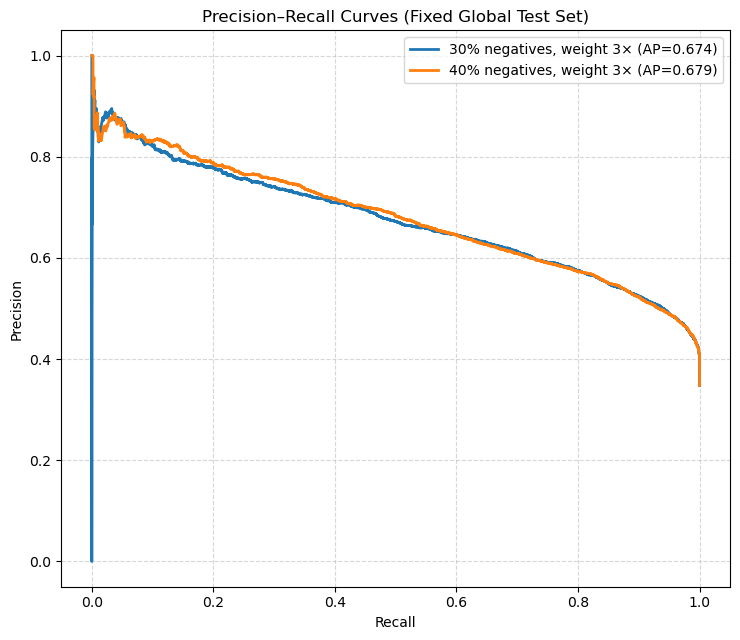


[SAVED] PR curve figure -> /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/neg_ratio_experiments_globaltest/option2_scale_pos_weight_penalize_fp/precision_recall_curves_selected.png


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

OUT_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/neg_ratio_experiments_globaltest/option2_scale_pos_weight_penalize_fp"

y_test_path = os.path.join(OUT_DIR, "y_test.npy")
if not os.path.exists(y_test_path):
    raise FileNotFoundError(f"Missing y_test.npy at {y_test_path}. Re-run training with the save patch.")

y_test = np.load(y_test_path)

# Find per-sweep probabilities, e.g., y_test_proba_neg030_w3.npy or y_test_proba_neg030_w3.0.npy
proba_files = sorted(glob.glob(os.path.join(OUT_DIR, "y_test_proba_neg*_w*.npy")))
if not proba_files:
    raise FileNotFoundError(f"No y_test_proba_* files found in {OUT_DIR}. Re-run training with the save patch.")

# Allow decimal or integer weight: w3 or w3.0
pattern = re.compile(r"y_test_proba_neg(\d{3})_w(\d+(?:\.\d+)?)\.npy$")

# Choose which sweeps to plot (set USE_SELECT=False to plot ALL)
# NOTE: If your filenames use decimals (e.g., w3.0), key must be "030,3.0"
SELECT = {
    "030,3.0": "30% negatives, weight 3×",
    "040,3.0": "40% negatives, weight 3×",
}
USE_SELECT = True  # False -> plot every sweep found

# Discover available keys
available = []
for path in proba_files:
    m = pattern.search(os.path.basename(path))
    if m:
        neg_pct, w = m.group(1), m.group(2)  # e.g., '030', '3.0'
        available.append((neg_pct, w, path))

if not available:
    raise RuntimeError("Found files but none matched the expected pattern. Check filenames.")

print("\n[INFO] Available curves discovered:")
for neg_pct, w, p in available:
    print(f"  - neg={int(neg_pct)}%, w={w} -> {os.path.basename(p)}")

curves = []  # (rec, prec, label, ap)

for neg_pct, w, path in available:
    key = f"{neg_pct},{w}"  # e.g., "030,3.0"
    if USE_SELECT and key not in SELECT:
        continue

    y_prob = np.load(path)
    prec, rec, thr = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)

    label = SELECT[key] if USE_SELECT else f"NEG={int(neg_pct)}%, w={w}×"
    curves.append((rec, prec, f"{label} (AP={ap:.3f})", ap))

if not curves:
    # Helpful hint before failing
    wanted = ", ".join(SELECT.keys()) if USE_SELECT else "(all)"
    raise RuntimeError(f"No matching curves to plot for SELECT={wanted}. "
                       f"Either adjust SELECT keys to include decimal weights (e.g., '030,3.0'), "
                       f"or set USE_SELECT=False to plot all.")

plt.figure(figsize=(7.5, 6.5))
for rec, prec, label, ap in curves:
    plt.plot(rec, prec, lw=2, label=label)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Fixed Global Test Set)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()

out_png = os.path.join(
    OUT_DIR,
    "precision_recall_curves_selected.png" if USE_SELECT else "precision_recall_curves_all.png"
)
# plt.savefig(out_png, dpi=150)
# plt.close()
plt.show()
print(f"\n[SAVED] PR curve figure -> {out_png}")


MODIS

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch predict burned probabilities and classes for ALL requested years/months
using the saved Option 2 model (NEG=40%, neg_class_weight=3).

Outputs per (year, month):
  - <OUT_PRED_DIR>/proba/cems_pred_proba_{YYYY}_{MM}.tif
  - <OUT_PRED_DIR>/class/cems_pred_class_{YYYY}_{MM}_thr{thr}.tif
"""

import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa

import rasterio as rio
from rasterio.warp import transform as rio_transform
from rasterio.transform import rowcol

import lightgbm as lgb
import joblib

# ============================ CONFIG ============================
# Years & months to process
YEARS  = list(range(2001, 2024))   # change as needed
MONTHS = list(range(1, 13))        # 1..12

# Where your ORIGINAL template monthly TIFFs live (for georeference/shape)
IN_TIF_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_mcd_with_fraction"

# The Parquet dataset you built from those TIFFs (partitioned by year=/month=)
PARQUET_DATASET_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_mcd"

# Saved model metadata JSON for NEG=40% & w_neg=3 from the penalize-FP run
MODEL_META_JSON = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/"
    "neg_ratio_experiments_globaltest/option2_scale_pos_weight_penalize_fp/"
    "saved_model_neg040pct_w3/model_meta_neg040pct_w3.json"
)

# Where to save prediction rasters
OUT_PRED_DIR = (
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "predictions_option2_neg040pct_w3_mcd"
)
os.makedirs(os.path.join(OUT_PRED_DIR, "proba"), exist_ok=True)
os.makedirs(os.path.join(OUT_PRED_DIR, "class"), exist_ok=True)

# Parquet lon/lat handling
PARQUET_COORDS_ARE_EPSG4326 = True

# Batch size for reading Parquet
PARQUET_BATCH_ROWS = 1_000_000

# ================================================================
# Helpers
# ================================================================
name_re = re.compile(r"cems_e5l_mcd_(\d{4})_(\d{1,2})", re.IGNORECASE)

def parse_year_month(fname: str):
    m = name_re.search(fname)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

def find_template_tif(year: int, month: int) -> Path:
    """Find the template GeoTIFF for the given year/month."""
    patterns = [
        f"cems_e5l_mcd_{year}_{month}_with_fraction.tif",
        f"cems_e5l_mcd_{year}_{month}.tif",
        f"cems_e5l_mcd_{year}_{month:02d}_with_fraction.tif",
        f"cems_e5l_mcd_{year}_{month:02d}.tif",
    ]
    for p in patterns:
        cand = Path(IN_TIF_DIR) / p
        if cand.exists():
            return cand
    for tif in Path(IN_TIF_DIR).glob(f"cems_e5l_mcd_{year}_*.tif"):
        y, m = parse_year_month(tif.name)
        if y == year and m == month:
            return tif
    return None

def load_model_and_meta(meta_json_path: str):
    """Load model + metadata; return (model, booster, predictors, b1_cats, threshold, best_iter, meta)."""
    with open(meta_json_path, "r") as f:
        meta = json.load(f)
    pkl_path = meta["paths"].get("sklearn_pkl")
    booster_txt = meta["paths"].get("booster_txt")
    predictors = meta.get("predictors", [])
    b1_cats = None
    if meta.get("categorical", {}).get("b1_categories") is not None:
        b1_cats = [str(x) for x in meta["categorical"]["b1_categories"]]
    threshold = float(meta.get("threshold", 0.5))
    best_iteration = meta.get("best_iteration", -1)

    if pkl_path and os.path.exists(pkl_path):
        model = joblib.load(pkl_path)  # LGBMClassifier
        booster = model.booster_
    elif booster_txt and os.path.exists(booster_txt):
        booster = lgb.Booster(model_file=booster_txt)
        model = booster
    else:
        raise FileNotFoundError("Neither sklearn_pkl nor booster_txt found from metadata paths.")

    return model, booster, predictors, b1_cats, threshold, best_iteration, meta

def ensure_predictor_frame(df: pd.DataFrame, predictors: list, b1_cats):
    """Ensure df has all predictor columns with correct types/order."""
    for c in predictors:
        if c not in df.columns:
            df[c] = np.nan
    X = df[predictors].copy()

    if "b1" in X.columns:
        X["b1"] = X["b1"].astype("string")
        if b1_cats is not None:
            X["b1"] = pd.Categorical(X["b1"], categories=b1_cats)
        else:
            X["b1"] = pd.Categorical(X["b1"])

    for c in X.columns:
        if c == "b1" and pd.api.types.is_categorical_dtype(X[c]):
            continue
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

def write_geotiff(path, array2d, template_ds, nodata=np.nan, dtype="float32"):
    profile = template_ds.profile.copy()
    profile.update(
        count=1,
        dtype=dtype,
        nodata=nodata if (isinstance(nodata, (int, float)) and not np.isnan(nodata)) else None,
        compress="deflate",
        predictor=2,
        tiled=True
    )
    with rio.open(path, "w", **profile) as dst:
        dst.write(array2d.astype(dtype), 1)

# ================================================================
# Load model + metadata
# ================================================================
model, booster, predictors, b1_cats, THRESH_PROBA, best_iter, meta = load_model_and_meta(MODEL_META_JSON)
print(f"[Model loaded: NEG=40%, w=3]")
print(f"  - Threshold: {THRESH_PROBA:.3f}")
print(f"  - Best iteration: {best_iter}")
print(f"  - #predictors: {len(predictors)}")

# Prepare Parquet dataset handle once
dataset = ds.dataset(PARQUET_DATASET_DIR, format="parquet", partitioning="hive")

# ================================================================
# Predict for requested YEARS × MONTHS
# ================================================================
for YEAR in YEARS:
    for MONTH in MONTHS:
        template_path = find_template_tif(YEAR, MONTH)
        if template_path is None:
            print(f"[SKIP] No template TIF in {IN_TIF_DIR} for {YEAR}-{MONTH:02d}")
            continue

        print(f"\n=== Predicting {YEAR}-{MONTH:02d} ===")

        with rio.open(template_path) as tpl:
            height, width = tpl.height, tpl.width
            transform = tpl.transform
            dst_crs = tpl.crs

            proba_arr = np.full((height, width), np.nan, dtype="float32")
            class_arr = np.full((height, width), 255, dtype="uint8")  # 255 nodata

            filt = (ds.field("year") == YEAR) & (ds.field("month") == MONTH)
            needed_cols = list(set(predictors + ["longitude", "latitude", "year", "month"]))

            scanner = ds.Scanner.from_dataset(
                dataset, columns=needed_cols, filter=filt, batch_size=PARQUET_BATCH_ROWS
            )

            total_rows = 0
            written_rows = 0

            for batch in scanner.to_batches():
                if batch.num_rows == 0:
                    continue
                tbl = pa.Table.from_batches([batch])
                df = tbl.to_pandas()
                total_rows += len(df)
                if len(df) == 0:
                    continue

                if "longitude" not in df.columns or "latitude" not in df.columns:
                    raise ValueError("Parquet dataset must include 'longitude' and 'latitude' columns.")

                lons = df["longitude"].to_numpy(dtype="float64", copy=False)
                lats = df["latitude"].to_numpy(dtype="float64", copy=False)

                # Build predictors frame with correct order/types
                X = ensure_predictor_frame(df, predictors, b1_cats)

                # Predict probabilities
                if hasattr(model, "predict_proba"):
                    proba = model.predict_proba(X, num_iteration=getattr(model, "best_iteration_", None))[:, 1]
                else:
                    proba = booster.predict(
                        X,
                        num_iteration=best_iter if isinstance(best_iter, int) and best_iter > 0 else None
                    )

                # Map coordinates to row/col in template CRS
                if PARQUET_COORDS_ARE_EPSG4326 and (dst_crs is not None) and (dst_crs.to_string().upper() not in ("EPSG:4326", "OGC:CRS84")):
                    xs, ys = rio_transform("EPSG:4326", dst_crs, lons, lats)
                else:
                    xs, ys = lons, lats

                # Convert to row/col (chunked to avoid overhead)
                step = 500_000
                npts = len(xs)
                rows_all = np.empty(npts, dtype=np.int64)
                cols_all = np.empty(npts, dtype=np.int64)
                for s in range(0, npts, step):
                    e = s + step
                    rr, cc = rowcol(transform, xs[s:e], ys[s:e], op=round)
                    rows_all[s:e] = rr
                    cols_all[s:e] = cc

                # Keep only points inside raster bounds
                mask_in = (
                    (rows_all >= 0) & (rows_all < height) &
                    (cols_all >= 0) & (cols_all < width)
                )
                if not np.any(mask_in):
                    continue

                rr = rows_all[mask_in]
                cc = cols_all[mask_in]
                pp = proba[mask_in]

                # Write to arrays
                proba_arr[rr, cc] = pp.astype("float32")
                class_arr[rr, cc] = (pp >= THRESH_PROBA).astype("uint8")
                written_rows += int(mask_in.sum())

            # Save rasters
            out_proba = Path(OUT_PRED_DIR) / "proba" / f"cems_pred_proba_{YEAR}_{MONTH:02d}.tif"
            out_class = Path(OUT_PRED_DIR) / "class" / f"cems_pred_class_{YEAR}_{MONTH:02d}_thr{THRESH_PROBA:.3f}.tif"

            write_geotiff(str(out_proba), proba_arr, tpl, nodata=np.nan, dtype="float32")
            write_geotiff(str(out_class), class_arr, tpl, nodata=255, dtype="uint8")

            print(f"[{YEAR}-{MONTH:02d}] wrote {written_rows:,}/{total_rows:,} rows ->")
            print(f"  - {out_proba}")
            print(f"  - {out_class}")

print("\n✅ Done. All requested predictions written.")


[Model loaded: NEG=40%, w=3]
  - Threshold: 0.414
  - Best iteration: 100
  - #predictors: 15

=== Predicting 2001-01 ===
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytr